# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 206483216

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x1eb7fa8bc10>, <__main__.Node at 0x1eb7fa8bfa0>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
# TODO: Find columns with missing values and remove them from the data
data.isnull().sum()

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
class                       0
dtype: int64

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0
    s1 = sum(data[:,-1] == 'p') / len(data[:,-1])
    s2 = sum(data[:,-1] == 'e') / len(data[:,-1])
    gini = 1 - (s1**2 + s2**2)
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    s1 = sum( data[:,-1] == 'p' ) / len(data[:,-1])
    s2 = sum( data[:,-1] == 'e' ) / len(data[:,-1])
    entropy = -s1 * np.log2(s1)  -s2 * np.log2(s2)
    return entropy

In [10]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

In [11]:
# Y counter
print(sum(X[:,-1] == 'p'))
print(sum(X[:,-1] == 'e'))

3942
4182


## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio= False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.

    Returns the goodness of split.  
    """
    
    feat_data = data[:,feature]
    parent = impurity_func(data)
    num_of_val = np.unique(feat_data)
    impurity_children = 0
    split_info = 0
    for value in num_of_val:
        
        # what I need in order to calculate info gain    
        prop = sum( feat_data == value) / len(feat_data)
        child = data [ feat_data == value ] 
        impurity_children += prop * impurity_func(child)
    goodness = parent - impurity_children 
    
    if gain_ratio:
        #what I need in order to calculate gain ratio        
        prob = np.unique(data[:,feature] , return_counts = True)[1] / len(data)
        if len(prob) != 1: # the feature needs to be impure (with out just 1 unique value)
            split_info = - np.sum(prob * np.log2(prob) )
            goodness = goodness / split_info
    return goodness   


In [13]:
#Self Check
goodness_of_split(X,16,calc_entropy)

0.024544175941411783

In [14]:
#Another self check
print(np.unique(X[:,16]))
n_prop = sum(X[:,16] == 'n') / len(X[:,16])
o_prop = sum(X[:,16] == 'o') / len(X[:,16])
t_prop = sum(X[:,16] == 't') / len(X[:,16])

n_rows = X[X[:,16] == 'n']
o_rows = X[X[:,16] == 'o']
t_rows = X[X[:,16] == 't']

calc_entropy(X) - (n_prop * calc_entropy(n_rows) + o_prop * calc_entropy(o_rows) + t_prop * calc_entropy(t_rows)) == goodness_of_split(X,16,calc_entropy)

['n' 'o' 't']


True

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [15]:
class DecisionNode():
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, data, feature=None, value=None, is_root=True, is_leaf=False, depth=0):
        self.data = data
        self.feature = feature # column index of criteria being tested
        self.value = value
        self.children = []
        self.is_root = is_root
        self.is_leaf = is_leaf
        self.depth = depth
        
    # get and set method for data parameter
    def get_data(self):
        return self.data
    
    def set_data(self, data):
        self.data = data
        
    # get and set method for feature parameter
    def get_feature(self):
        return self.feature
    
    def set_feature(self, feature):
        self.feature = feature
        
    # get and set method for value parameter
    def get_value(self):
        return self.value
    
    def set_value(self, value):
        self.value = value
        
    # get and set method for children parameter
    def get_children(self):
        return self.children
    
    def set_children(self, children):
        self.children = children
        
    # get and set method for is_root parameter
    def get_is_root(self):
        return self.is_root
    
    def set_is_root(self, is_root):
        self.is_root = is_root
    
    # get and set method for is_leaf parameter
    def get_is_leaf(self):
        return self.is_leaf
    
    def set_is_leaf(self, is_leaf):
        self.is_leaf = is_leaf
        
    # get and set method for depth parameter
    def get_depth(self):
        return self.depth
    
    def set_depth(self, depth):
        self.depth = depth  
        
        
    def add_child(self, node):
        self.children.append(node)
        
        
    def split_node(self, impurity_func, min_samples_split, max_depth, gain_ratio):
        goodness = []
        data = self.get_data()
        father_depth = self.get_depth()
        
        if self.get_is_leaf() == False:
            
            for i in range (data.shape[1]-1):
                info_gain = goodness_of_split(data, i, impurity_func, gain_ratio)
                goodness.append(info_gain)
            max_goodness_i = np.argmax(goodness) #The best information gain 
            self.set_feature(max_goodness_i)
            un_val = np.unique(data[:, max_goodness_i])
            for val in un_val:
                #Child
                node_data = data[data[:,max_goodness_i]==val]
                node = DecisionNode(data = node_data, value = val, is_root=False)
                node.set_depth(father_depth+1)
                node.check_leaf()
                self.add_child(node)
                
            for child in self.get_children():
                if child.get_depth() < max_depth: #The minimum depth of the child must be less than the maximum depth in order to generate additional childrens
                    if len(child.get_data()) >= min_samples_split:
                        child.split_node(impurity_func, min_samples_split, max_depth, gain_ratio)
                          
            
    def check_leaf(self):
        data = self.get_data()
        unique_labels = set(data[:, -1])  # Extract unique labels from the dataset
        if len(unique_labels) == 1:  # If there is only one unique label
            self.set_is_leaf(True)  # Set the "is_leaf" attribute to True

In [16]:
def build_tree(data, impurity, min_samples_split=1, max_depth=1000, gain_ratio=False):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    root = DecisionNode(data)
    root.split_node(impurity, min_samples_split, max_depth, gain_ratio)
    return root

In [17]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

print(tree_gini)
print(tree_entropy)
print(tree_entropy_gain_ratio)

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [18]:
def predict(node, instance):
    """
    Predict the class label of a given instance using a decision tree.
 
    Inputs:
    - node: the current node in the decision tree.
    - instance: a row vector from the dataset. The last element 
                of this vector is the label of the instance.
 
    Output:
    - The prediction of the instance.
    """
    predictions = []
    count_no_match_children = 0
    for child in node.get_children():
        if instance[node.get_feature()] == child.get_value():
            if not child.get_is_leaf():
                predictions += predict(child, instance)  # Using recursion to reach the leaf node
            else:
                # Checking the majority in the target variable
                data = child.get_data()
                count_label_e = sum(data[:, -1] == 'e')
                count_label_p = sum(data[:, -1] == 'p')
                if count_label_e > count_label_p:
                    predictions.append('e')
                else:
                    predictions.append('p')
        else:
            count_no_match_children += 1
            
    # Check if the value is not in the tree, and classify the instance based on the last node it could have reached
    if len(node.get_children()) == count_no_match_children:
        data = node.get_data()
        count_label_e = sum(data[:, -1] == 'e')
        count_label_p = sum(data[:, -1] == 'p')
        if count_label_e > count_label_p:
            predictions.append('e')
        else:
            predictions.append('p')
    #return predictions
    return predictions[0]


In [19]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    count_correct = 0
    for instance in dataset:
        prediction = predict(node, instance)
        if prediction == instance[-1]:
            count_correct += 1
        
    accuracy = count_correct / len(dataset)

    return accuracy 

In [20]:
#Self Check
for instance in X_test[0:5]:
    actual = instance[-1]
    prediction = predict(tree_gini, instance)
    print("Last Column Value:", actual)
    print("Prediction:", prediction)
    print()


Last Column Value: e
Prediction: e

Last Column Value: e
Prediction: e

Last Column Value: e
Prediction: e

Last Column Value: p
Prediction: p

Last Column Value: p
Prediction: p



After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [21]:
print('The tree_gini train accuracy is: ', calc_accuracy(tree_gini,X_train) )
print('The tree_gini test accuracy is: ', calc_accuracy(tree_gini,X_test) )

The tree_gini train accuracy is:  0.9937633349745609
The tree_gini test accuracy is:  0.7769571639586411


In [22]:
print('The tree_entropy train accuracy is: ',calc_accuracy(tree_entropy,X_train) )
print('The tree_entropy test accuracy is: ',calc_accuracy(tree_entropy,X_test) )

The tree_entropy train accuracy is:  0.9960610536681438
The tree_entropy test accuracy is:  0.810930576070901


In [23]:
print('The tree_entropy_gain_ratio train accuracy is: ',calc_accuracy(tree_entropy_gain_ratio,X_train) )
print('The tree_entropy_gain_ratio test accuracy is: ',calc_accuracy(tree_entropy_gain_ratio,X_test) )

The tree_entropy_gain_ratio train accuracy is:  0.9963892991957984
The tree_entropy_gain_ratio test accuracy is:  0.811422944362383


#### The accuracy on tree_entropy_gain_ratio test data is the highest

## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

In [24]:
train_accuracy_list = []
test_accuracy_list = []
best_accuracy = 0
best_depth = 0

for depth in range(1, 9):
    tree = build_tree(X_train, impurity=calc_entropy, gain_ratio=True, max_depth=depth)
    train_accuracy = calc_accuracy(tree, X_train)
    test_accuracy = calc_accuracy(tree, X_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_depth = depth


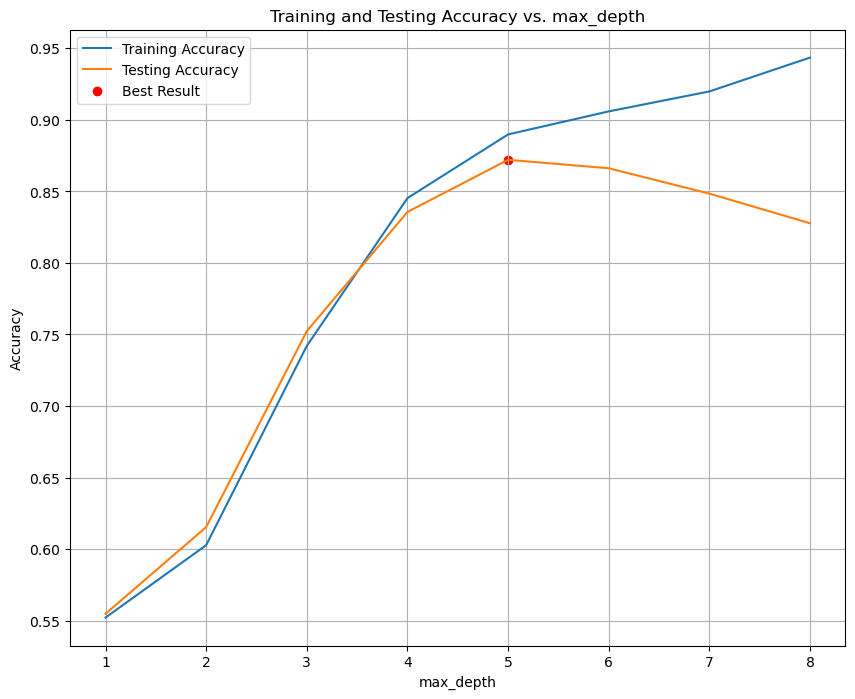

In [25]:
#I was helped by Chat GPT
import matplotlib.pyplot as plt

max_depth_values = range(1, 9)

plt.plot(max_depth_values, train_accuracy_list, label='Training Accuracy')
plt.plot(max_depth_values, test_accuracy_list, label='Testing Accuracy')

#best result
best_depth_index = best_depth - 1
best_train_accuracy = train_accuracy_list[best_depth_index]
best_test_accuracy = test_accuracy_list[best_depth_index]
plt.scatter(best_depth, best_accuracy, color='red', marker='o', label='Best Result')

plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. max_depth')
plt.legend()
plt.grid(True)
plt.show()

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

In [26]:
train_accuracy_list = []
test_accuracy_list = []
best_accuracy = 0
best_min_samples = 0

for min_samples in [1, 5, 10, 20, 50]:
    tree = build_tree(X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=min_samples)
    train_accuracy = calc_accuracy(tree, X_train)
    test_accuracy = calc_accuracy(tree, X_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_min_samples = min_samples


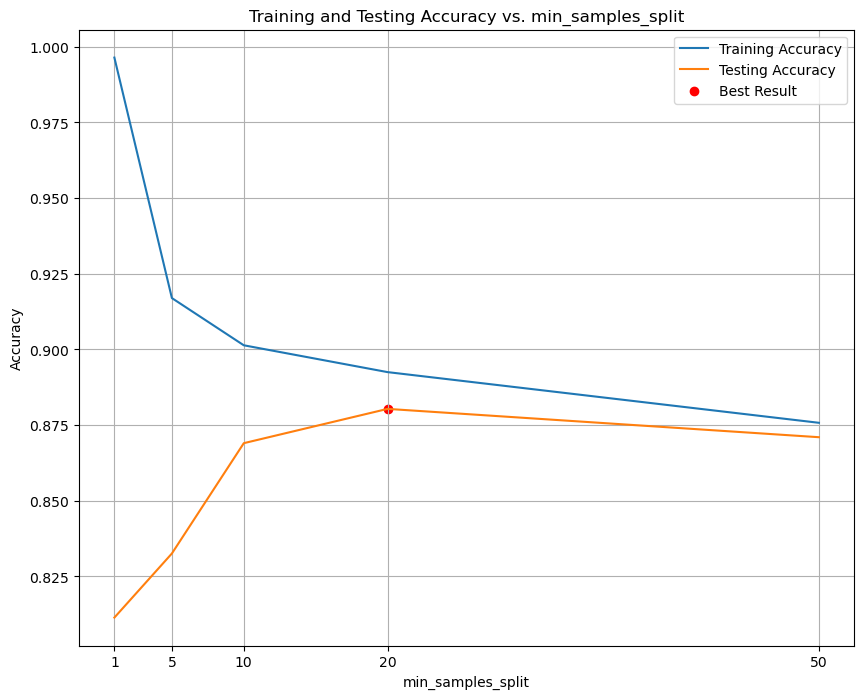

In [27]:
#I was helped with Chat GPT

min_samples_values = [1, 5, 10, 20, 50]

plt.plot(min_samples_values, train_accuracy_list, label='Training Accuracy')
plt.plot(min_samples_values, test_accuracy_list, label='Testing Accuracy')

#best result
best_min_samples_index = min_samples_values.index(best_min_samples)
best_train_accuracy = train_accuracy_list[best_min_samples_index]
best_test_accuracy = test_accuracy_list[best_min_samples_index]
plt.scatter(best_min_samples, best_accuracy, color='red', marker='o', label='Best Result')

plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs. min_samples_split')
plt.xticks(min_samples_values)
plt.legend()
plt.grid(True)
plt.show()


Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [28]:
#Entropy + gain_ratio=True + max_depth= 5
tree_max_depth = build_tree(X_train, impurity = calc_entropy, gain_ratio=True, max_depth= 5) 

#Entropy + gain_ratio=True + min_samples_split= 20
tree_min_samples_split = build_tree(X_train, impurity = calc_entropy, gain_ratio=True, min_samples_split= 20)

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [29]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    if node.get_is_leaf():
        return 1
    
    count = 1
    for child in node.get_children():
        count += count_nodes(child)
    
    return count


In [30]:
print("Number of nodes in tree_gini:", count_nodes(tree_gini))
print("Number of nodes in tree_entropy:", count_nodes(tree_entropy))
print("Number of nodes in tree_entropy_gain_ratio:", count_nodes(tree_entropy_gain_ratio)) 
print("Number of nodes in tree_with_max_depth:", count_nodes(tree_max_depth))
print("Number of nodes in tree_with_min_samples_split:", count_nodes(tree_min_samples_split))

Number of nodes in tree_gini: 22136
Number of nodes in tree_entropy: 15649
Number of nodes in tree_entropy_gain_ratio: 14636
Number of nodes in tree_with_max_depth: 721
Number of nodes in tree_with_min_samples_split: 886


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [31]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    
    if parent_feature=='ROOT':
        print( f'[{parent_feature}, feature=X{node.get_feature()}]')


    for child in node.get_children():
        if child.get_feature() != None: # checking if the node is leaf
            print('   ' * (child.get_depth()) + f'[X{node.get_feature()}={child.get_value()}, feature=X{child.get_feature()}]')
            print_tree(child, parent_feature = node.get_feature() )
        else:
            data = child.get_data()
            decision_e = sum(data[:, -1]=='e')
            decision_p = sum(data[:, -1]=='p')
            if decision_e == 0:
                print('   ' * (child.get_depth()) + f'[X{node.get_feature()}={child.get_value()}, Leaf]: [p: {decision_p}]')
            elif decision_p == 0:
                print('   ' * (child.get_depth()) + f'[X{node.get_feature()}={child.get_value()}, Leaf]: [e: {decision_e}]')
            else:
                print('   ' * (child.get_depth()) + f'[X{node.get_feature()}={child.get_value()}, Leaf]: [e: {decision_e}, p: {decision_p}]')

        

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [32]:
best_tree_less_than_50_nodes_2_ent = build_tree(X_train, impurity = calc_entropy, gain_ratio = True, max_depth= 2, min_samples_split=20)
best_tree_less_than_50_nodes_2_gin = build_tree(X_train, impurity = calc_gini, gain_ratio = True, max_depth= 2, min_samples_split=20)

best_tree_less_than_50_nodes_3_ent = build_tree(X_train, impurity = calc_entropy, gain_ratio = True, max_depth= 3, min_samples_split=20)
best_tree_less_than_50_nodes_3_gin = build_tree(X_train, impurity = calc_gini, gain_ratio = True, max_depth= 3, min_samples_split=20)

best_tree_less_than_50_nodes_4_ent = build_tree(X_train, impurity = calc_entropy, gain_ratio = True, max_depth= 4, min_samples_split=20)
best_tree_less_than_50_nodes_4_gin = build_tree(X_train, impurity = calc_gini, gain_ratio = True, max_depth= 4, min_samples_split=20)

best_tree_less_than_50_nodes_5_ent = build_tree(X_train, impurity = calc_entropy, gain_ratio = True, max_depth= 5, min_samples_split=20)
best_tree_less_than_50_nodes_5_gin = build_tree(X_train, impurity = calc_gini, gain_ratio = True, max_depth= 5, min_samples_split=20)

trees = [
    best_tree_less_than_50_nodes_2_ent,
    best_tree_less_than_50_nodes_2_gin,
    best_tree_less_than_50_nodes_3_ent,
    best_tree_less_than_50_nodes_3_gin,
    best_tree_less_than_50_nodes_4_ent,
    best_tree_less_than_50_nodes_4_gin,
    best_tree_less_than_50_nodes_5_ent,
    best_tree_less_than_50_nodes_5_gin
]

best_accuracy = 0
best_tree = None

for i, tree in enumerate(trees):
    accuracy = calc_accuracy(tree, X_test)
    num_nodes = count_nodes(tree)

    print(f"Tree {i+1}:")
    print("Accuracy:", accuracy)
    print("Number of nodes:", num_nodes)
    print()


Tree 1:
Accuracy: 0.6154603643525357
Number of nodes: 33

Tree 2:
Accuracy: 0.8862629246676514
Number of nodes: 34

Tree 3:
Accuracy: 0.7523387493845396
Number of nodes: 122

Tree 4:
Accuracy: 0.8951255539143279
Number of nodes: 94

Tree 5:
Accuracy: 0.8360413589364845
Number of nodes: 286

Tree 6:
Accuracy: 0.8951255539143279
Number of nodes: 221

Tree 7:
Accuracy: 0.8724766125061546
Number of nodes: 537

Tree 8:
Accuracy: 0.8951255539143279
Number of nodes: 345



##### The tree with the best test accuarcy and less than 50 nodes is tree with gini impurity, max deapth 2 and minimum sample split of 20

In [33]:
print_tree(best_tree_less_than_50_nodes_2_gin)
print("\n The Tree Accuracy is:", calc_accuracy(best_tree_less_than_50_nodes_2_gin, X_test))

[ROOT, feature=X4]
   [X4=a, feature=X2]
      [X2=n, Leaf]: [e: 33, p: 5]
      [X2=w, Leaf]: [e: 107, p: 7]
      [X2=y, Leaf]: [e: 133, p: 19]
   [X4=c, feature=X6]
      [X6=c, Leaf]: [e: 7, p: 63]
      [X6=w, Leaf]: [e: 3, p: 74]
   [X4=f, feature=X10]
      [X10=f, Leaf]: [e: 14, p: 91]
      [X10=k, Leaf]: [e: 134, p: 1037]
      [X10=s, Leaf]: [e: 22, p: 310]
   [X4=l, feature=X1]
      [X1=f, Leaf]: [e: 19, p: 1]
      [X1=s, Leaf]: [e: 94, p: 16]
      [X1=y, Leaf]: [e: 159, p: 10]
   [X4=m, feature=X0]
      [X0=f, Leaf]: [e: 1, p: 8]
      [X0=k, Leaf]: [e: 1, p: 10]
      [X0=x, Leaf]: [p: 7]
   [X4=n, feature=X11]
      [X11=f, Leaf]: [e: 313, p: 41]
      [X11=k, Leaf]: [e: 108, p: 9]
      [X11=s, Leaf]: [e: 1899, p: 260]
      [X11=y, Leaf]: [e: 12, p: 34]
   [X4=p, feature=X0]
      [X0=f, Leaf]: [e: 7, p: 86]
      [X0=x, Leaf]: [e: 1, p: 89]
   [X4=s, feature=X13]
      [X13=p, Leaf]: [e: 12, p: 190]
      [X13=w, Leaf]: [e: 26, p: 190]
   [X4=y, feature=X1]
      